# Demo: Kalman Filter

##  Kalman Filter

In dieser Demo wollen wir den Kalman Filter etwas näher betrachten.

Diesmal brauchen wir keine OpenCV, sondern die numpy Bibliothek für Matrix Operationen und wir setzen auch geraden einige Parameter für die Simulation.

In [43]:
import numpy as np
# for displaying images in jupyter
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 200

# Zeitschritt für die Simulation
deltaT = 0.05

# Rauschmodell für den Kalmanfilter
sigmaSystemPos = 0.1
sigmaSystemVel = 0.1
sigmaMeasureX = 0.1
sigmaMeasureY = 0.1

# Tatsächlich verwendetes Rauschen für die Messung
sigmaMeasureXExperiment = 0.1
sigmaMeasureYExperiment = 0.1


### Zustand und Modelle

Wie können wir Superman helfen die Missile abzuwehren.

Wir möchten die Missile tracken. Diese wird mit einer Initialgeschwindigkeit von (10, 10) m/s vom Punkt (0, 0) abgeschossen und bewegt sich danach anhand der Schwerkraft (Beschleunigung = (0, -9.81) m^2/s).

Wie sieht der Zustandsvektor aus?

In [44]:
# Initialwerte
g = [0., -9.81]
posStart = [0., 0.]
velStart = [10., 10.]

# Zustand
x0 = np.asarray(posStart + velStart + g)
print(x0)

[ 0.    0.   10.   10.    0.   -9.81]


Wir haben hier die Gravitation dem Zustandsvektor beigefügt, auch wenn sie sich nicht ändert. Dies erlaubt es einfacher das System Modell als Matrix darzustellen. Dieses soll nun aus dem Zustandsvektor zu einem Zeitpunkt t den Zustandsvektor zum Zeitpunkt t+deltaT berechnen.

Dabei verändert sich die Position anhand der Geschwindigkeit und die Geschwindigkeit anhand der Beschleunigung. Die Beschleunigung selber bleibt gleich.

In [45]:
A = np.diag([1., 1., 1., 1., 1., 1.])
A[0,2] = deltaT;
A[1,3] = deltaT;
A[2,4] = deltaT;
A[3,5] = deltaT;

print(A)

[[1.   0.   0.05 0.   0.   0.  ]
 [0.   1.   0.   0.05 0.   0.  ]
 [0.   0.   1.   0.   0.05 0.  ]
 [0.   0.   0.   1.   0.   0.05]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


Wenn wir nun das Modell A auf x anwenden erhalten wir den nächsten Zustand:

In [46]:
x = np.matmul(A, x0)
print(x0)
print(x)

[ 0.    0.   10.   10.    0.   -9.81]
[ 0.5     0.5    10.      9.5095  0.     -9.81  ]


Wenn wir das für mehrere Schritte anwenden erhalten wir den durch das Systemmodell vorhergesagten Zustand der Missile.

In [47]:
steps = 50

# Die Werte für jeden Schritt werden in einem Array gespeichert
x = np.zeros(shape=(steps, x0.shape[0]))
x[0,:] = x0
for i in range(1,steps):
    x[i,:] = np.matmul(A, x[i-1,:])
    
    

Wir können die Position nun als Plot darstellen:

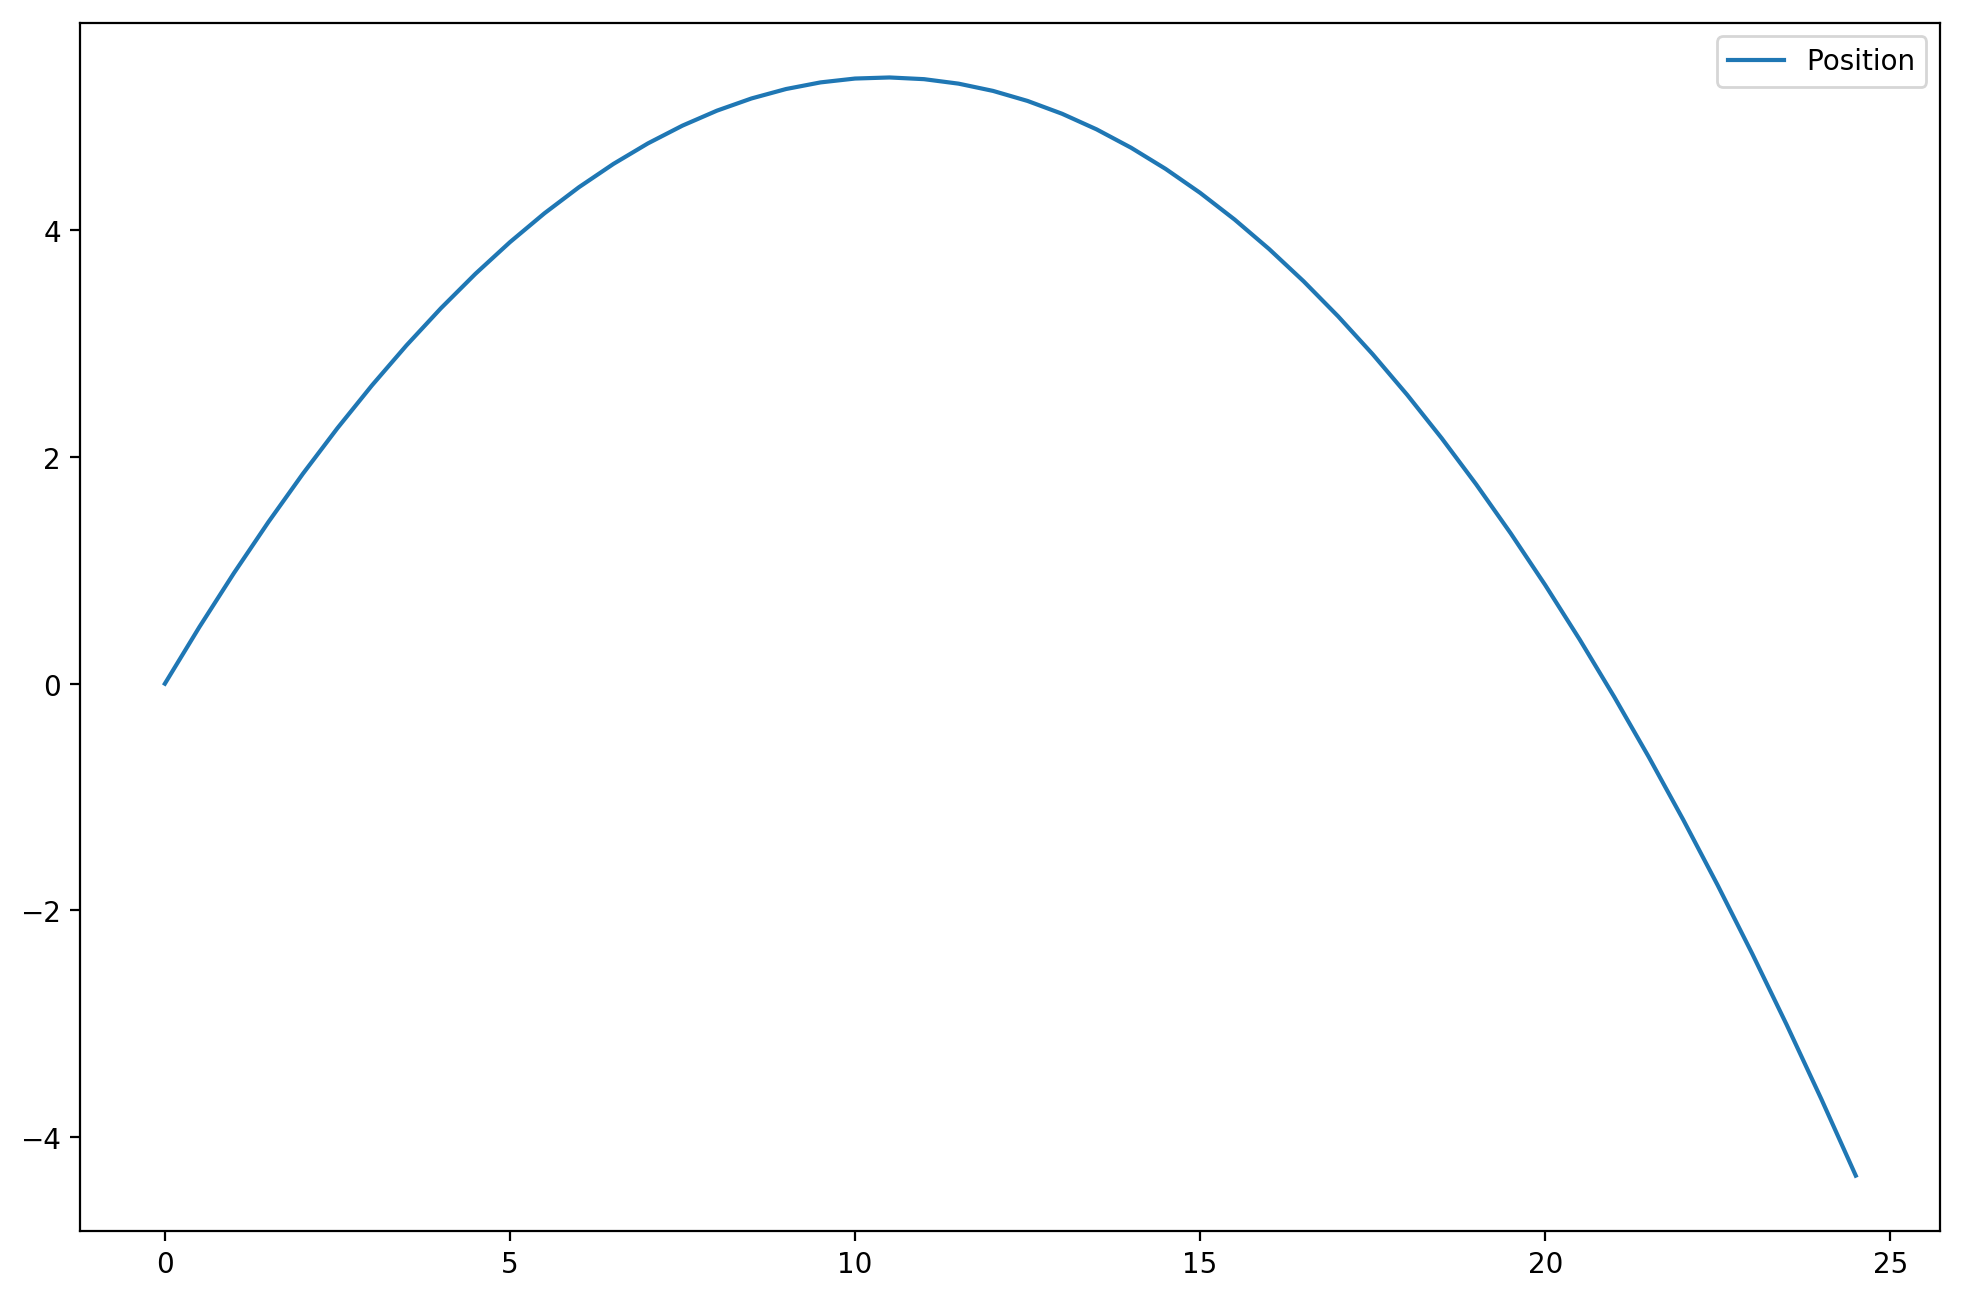

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x[:,0], x[:,1], label='Position')
ax.legend()

Für später brauchen wir auch noch das 'Noise' Modell des Systems. Dies beschreibt inwiefern wir dem System Modell vertrauen, zum Beispiel könnten wir den Luftwiderstand als Rauschen betrachten.

In [49]:
# System noise model
Q = np.zeros(shape=(6,6));
Q[0,0] = sigmaSystemPos;
Q[1,1] = sigmaSystemPos;
Q[2,2] = sigmaSystemVel;
Q[3,3] = sigmaSystemVel;
print(Q)

[[0.1 0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]]


Superman hat leider keinen Geschwindigkeitmesser und kann daher nur die Position der Missile messen. 

Um dies mathematisch darzustellen, brauchen wir eine Matrix C die aus dem Zustand die Messung, das heisst die x und y Position berechnet.

Wie sieht das Messmodell aus (Matrix C) aus?

In [50]:
# Messmodell
C = np.zeros(shape=(2,6));
C[0,0] = 1;
C[1,1] = 1;
print(C)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


Leider ist Supermann etwas weit entfernt und macht daher Fehler. Wir simulieren den Fehler in dem wir den Messergebnissen (Position) einen Gauss verteilten Zufallsvektor hinzufügen.

In [51]:
z = np.zeros(shape=(steps, 2))
for i in range(0,steps):
    z[i,0] = np.random.normal(loc=x[i,0], scale=sigmaMeasureXExperiment)
    z[i,1] = np.random.normal(loc=x[i,1], scale=sigmaMeasureYExperiment)

Nun können wir die Messungen darstellen:

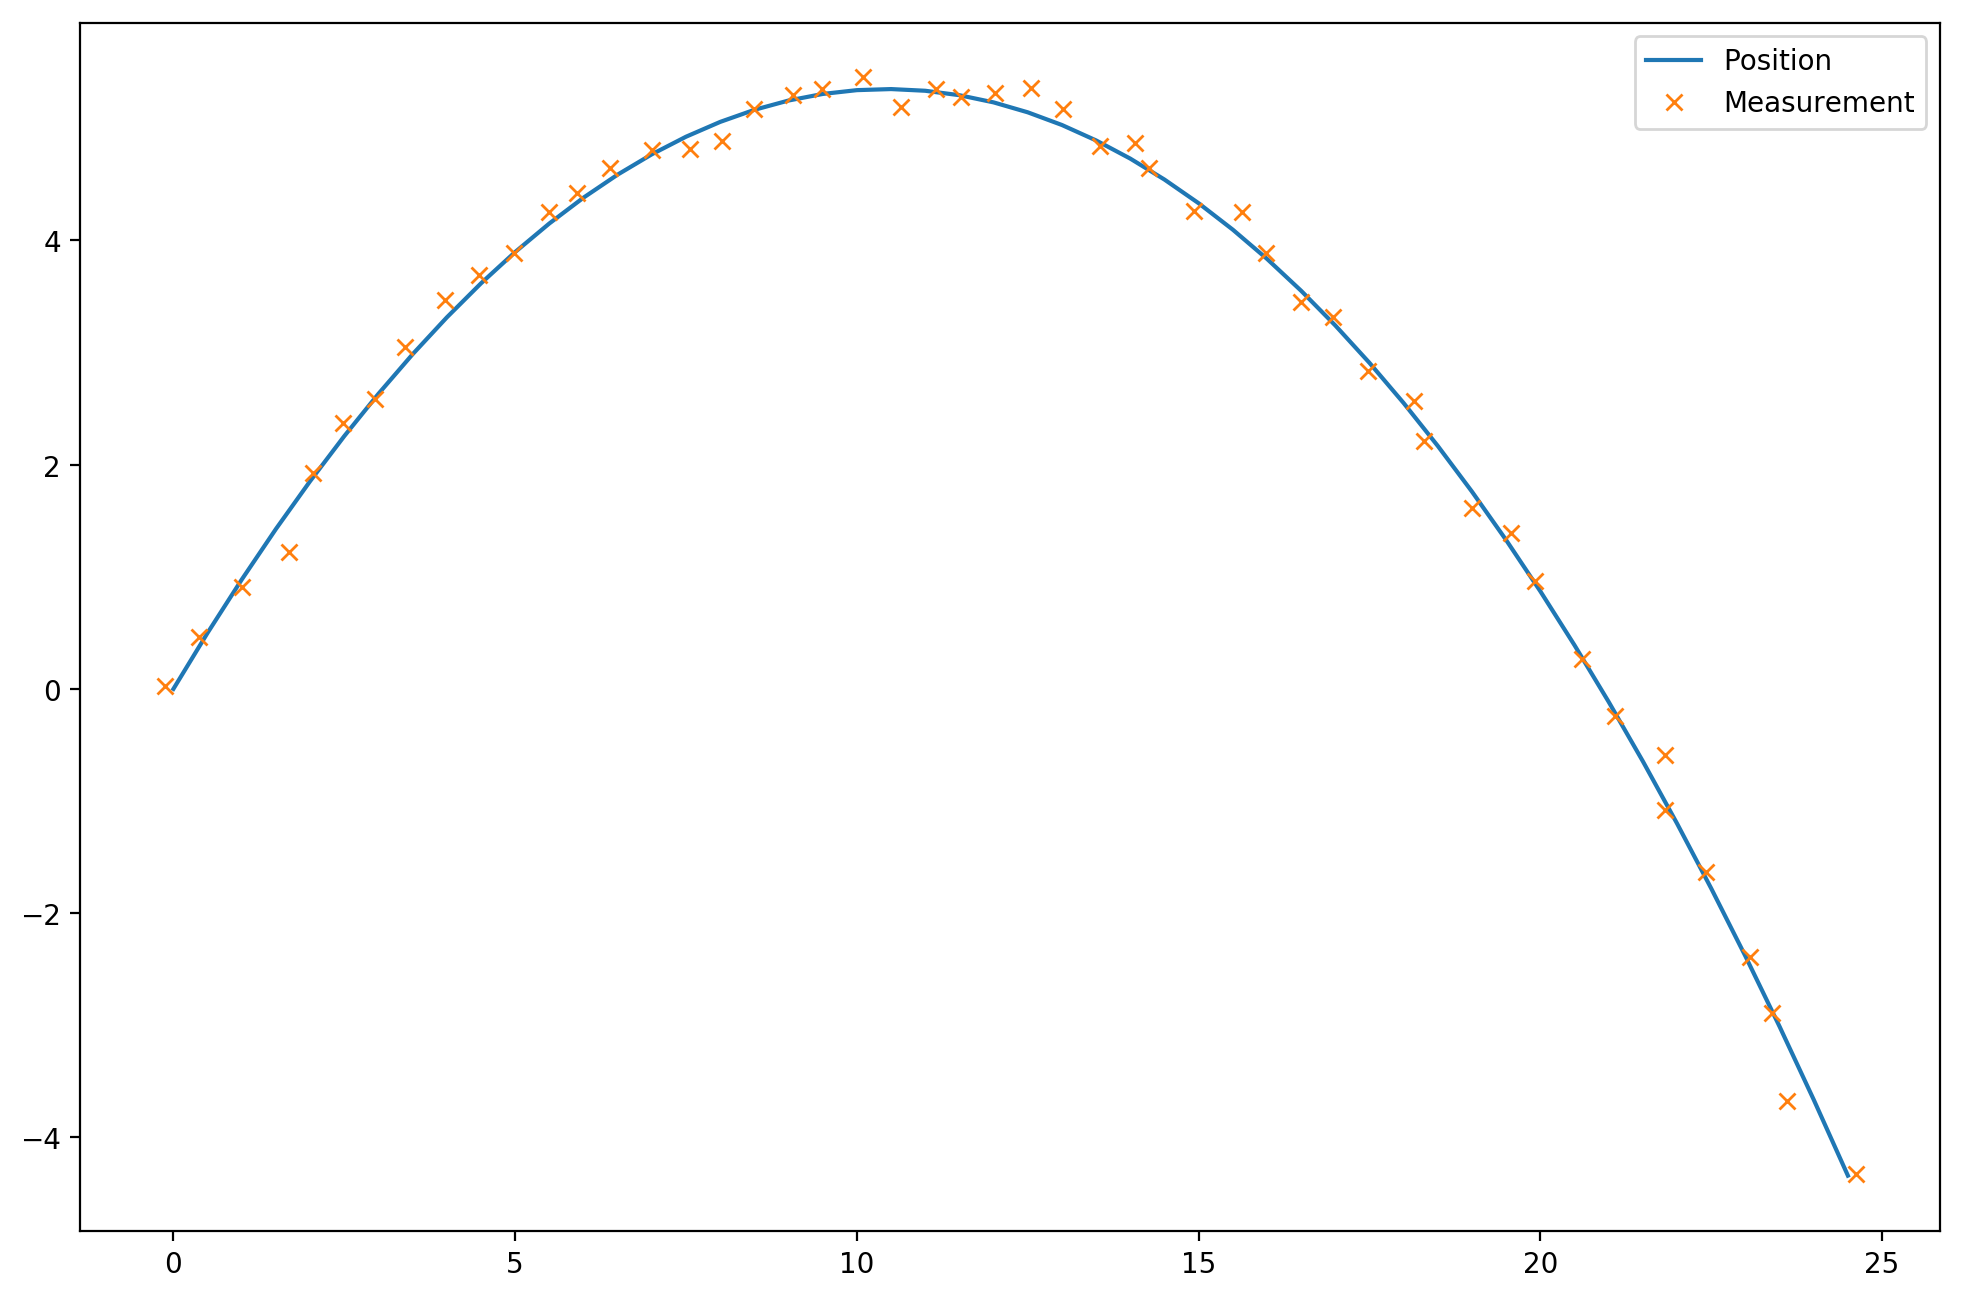

In [52]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x[:,0], x[:,1], label='Position')
ax.plot(z[:,0], z[:,1], marker='x', linestyle="None", label='Measurement')
ax.legend()

Für den Kalman Filter müssen wir nun auch noch den Messfehler als Matrix angeben.

In [53]:
# Messmodell Noise
R = np.zeros(shape=(2,2));
R[0,0] = sigmaMeasureX;
R[1,1] = sigmaMeasureY;
print(R)

[[0.3 0. ]
 [0.  0.3]]


### Implementation Kalman Filter

Den Kalman Filter selber möchten wir als Funktion definieren, die jeweils den nächsten Zustand (und die dazugehörige Kovarianzmatrix) aus dem aktuellen Zustand und der Messung berechnetn.


In [54]:
def kalman_step(A, C, Q, R, z, x, V, initial):
    """
    Args:
    A: the system matrix
    C: the observation matrix 
    Q: the system covariance 
    R: the observation covariance
    z: the observation at time t
    x: prior mean
    V: - prior covariance
    initial: true if this is an initial step (means x and V are taken as initial conditions (so A and Q are ignored)
    
    Returns:
      x_new: posterior mean
      V_new: posterior covariance

    """
    if initial:
        x_pred = x
        V_pred = V
    else:
        x_pred = np.matmul(A, x)
        V_pred = np.matmul(A, np.matmul(V, np.transpose(A))) + Q
        
    e = z - np.matmul(C, x_pred);
    C_trans = np.transpose(C)
    S = np.matmul(V_pred,C_trans)
    S = np.matmul(C, S) + R
    S_inverse = np.linalg.inv(S)

    # Kalman gain matrix
    K = np.matmul(np.matmul(V_pred, C_trans), S_inverse)
    
    x_res = x_pred + np.matmul(K, e)
    V_res = np.identity(V.shape[0]) - np.matmul(K, C)
    V_res = np.matmul(V_res, V_pred)
    
    return x_res, V_res
    


Nun können wir den Filter für jeden Zeitschritt anwenden und erhalten die gefilterten Resulte.

In [55]:
x_res = np.zeros(shape=(steps, 6))
V = np.zeros(shape=(6,6))
x_res[0,:], V = kalman_step(A, C, Q, R, z[0,:], x[0,:],V, initial=True)
for i in range(1,steps):
    x_res[i,:], V = kalman_step(A, C, Q, R, z[i,:], x_res[i-1,:],V, initial=False)

Plot des Resultats:

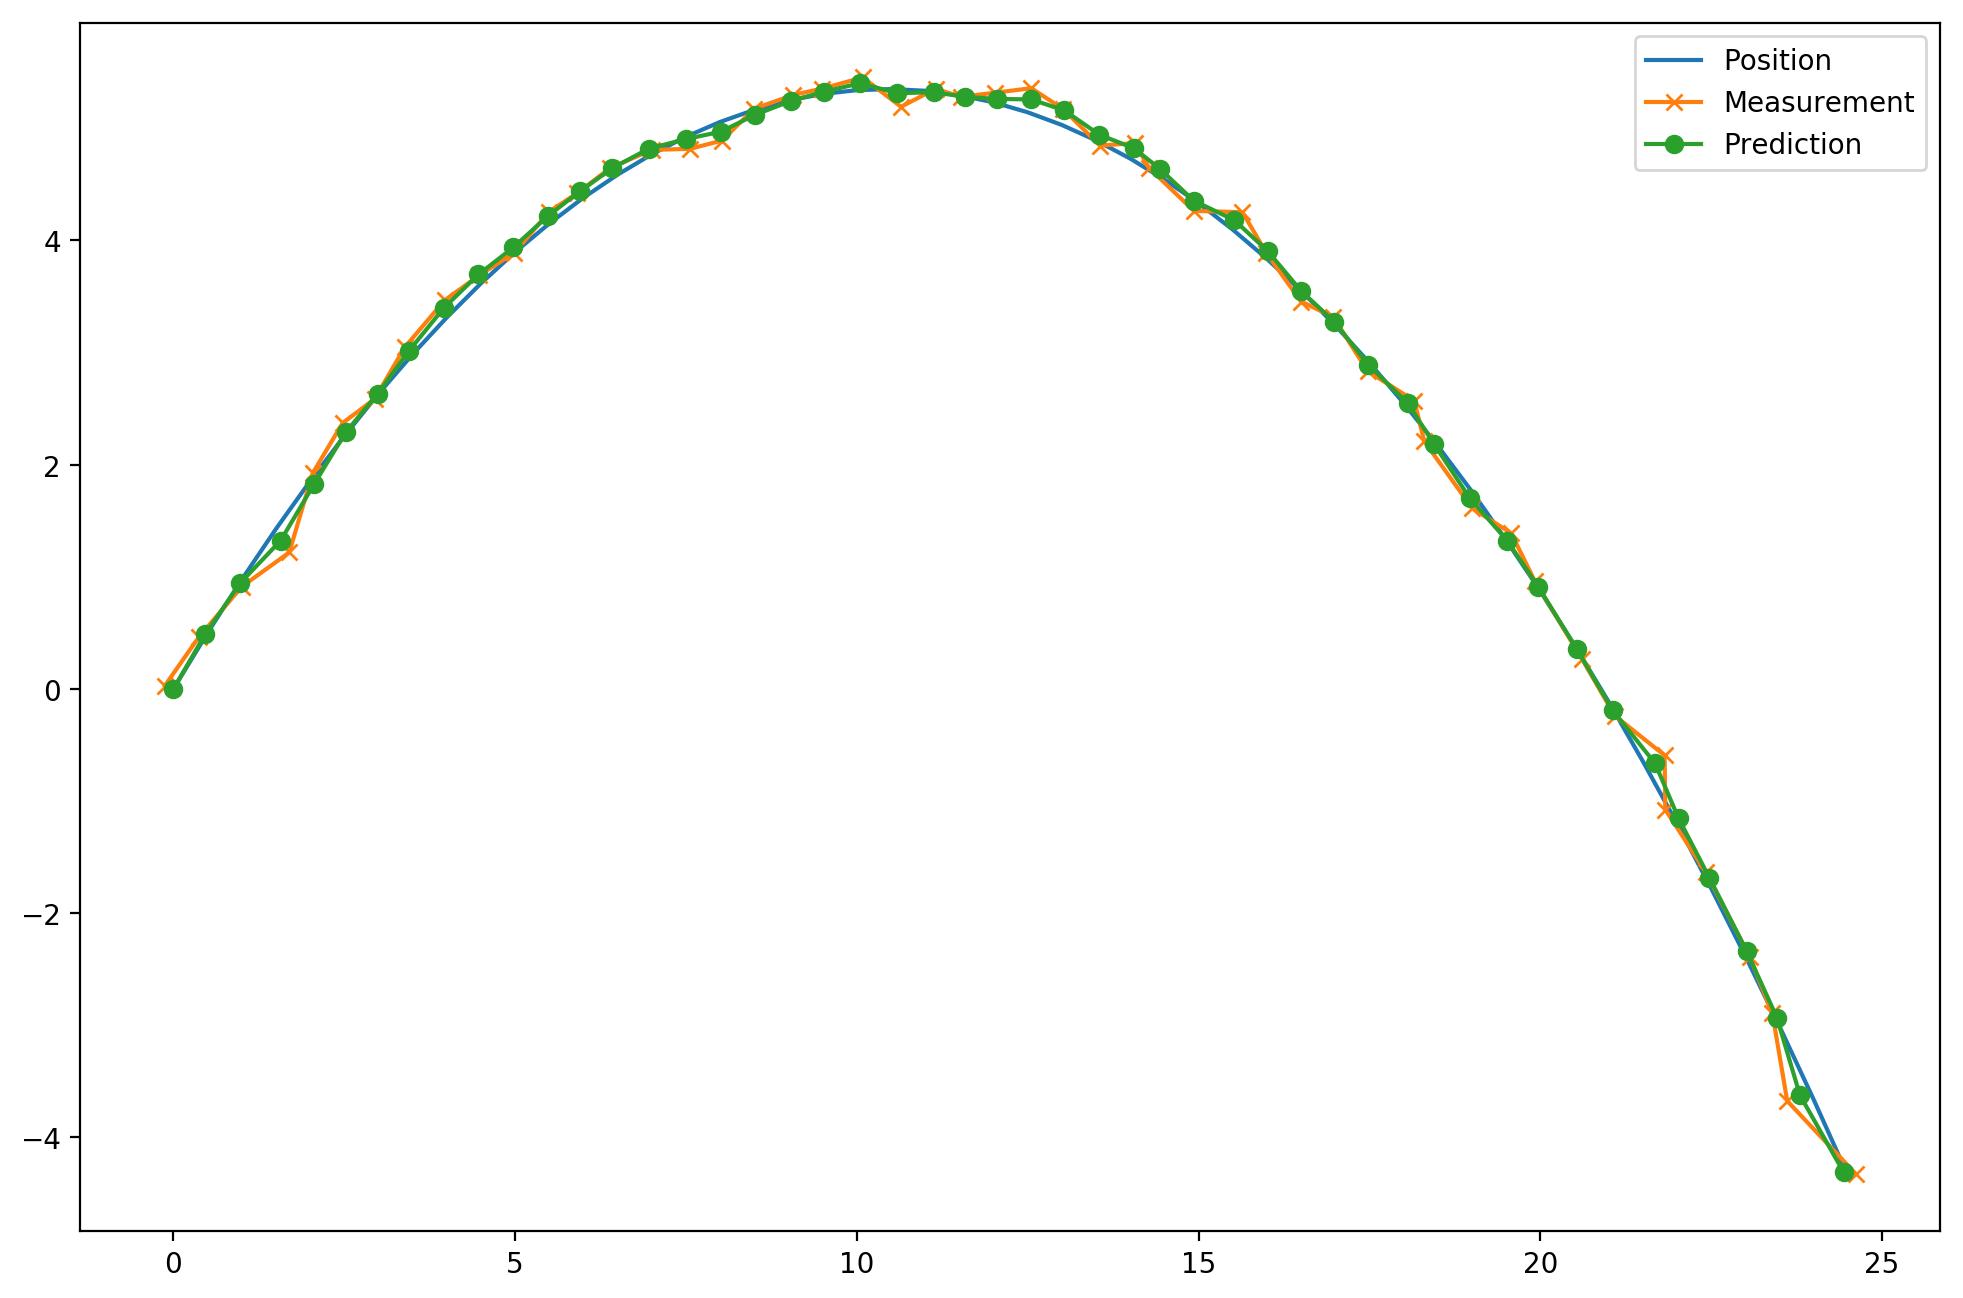

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x[:,0], x[:,1], label='Position')
ax.plot(z[:,0], z[:,1], marker='x', label='Measurement')
ax.plot(x_res[:,0], x_res[:,1], marker='o', label='Prediction')
ax.legend()

Im Resultat scheint die Messung etwas stark das Resultat zu beieinflussen. Wie könnte man das ändern?

Wenn wir noch den Luftwiderstand bei der Berechnung der richtigen Position (aber nicht bei den Modellen) berücksichtigen möchten, wie sieht es dann aus?